# 构建目标检测主干框架代码


Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Feature_inputs (InputLayer)     [(None, 10, 4356)]   0                                            
__________________________________________________________________________________________________
dense_62 (Dense)                (None, 10, 660)      2875620     Feature_inputs[0][0]             
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 10, 16)       10576       dense_62[0][0]                   
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, 10, 16)       31696       dense_62[0][0]                   
___________________________________________________________________________________________

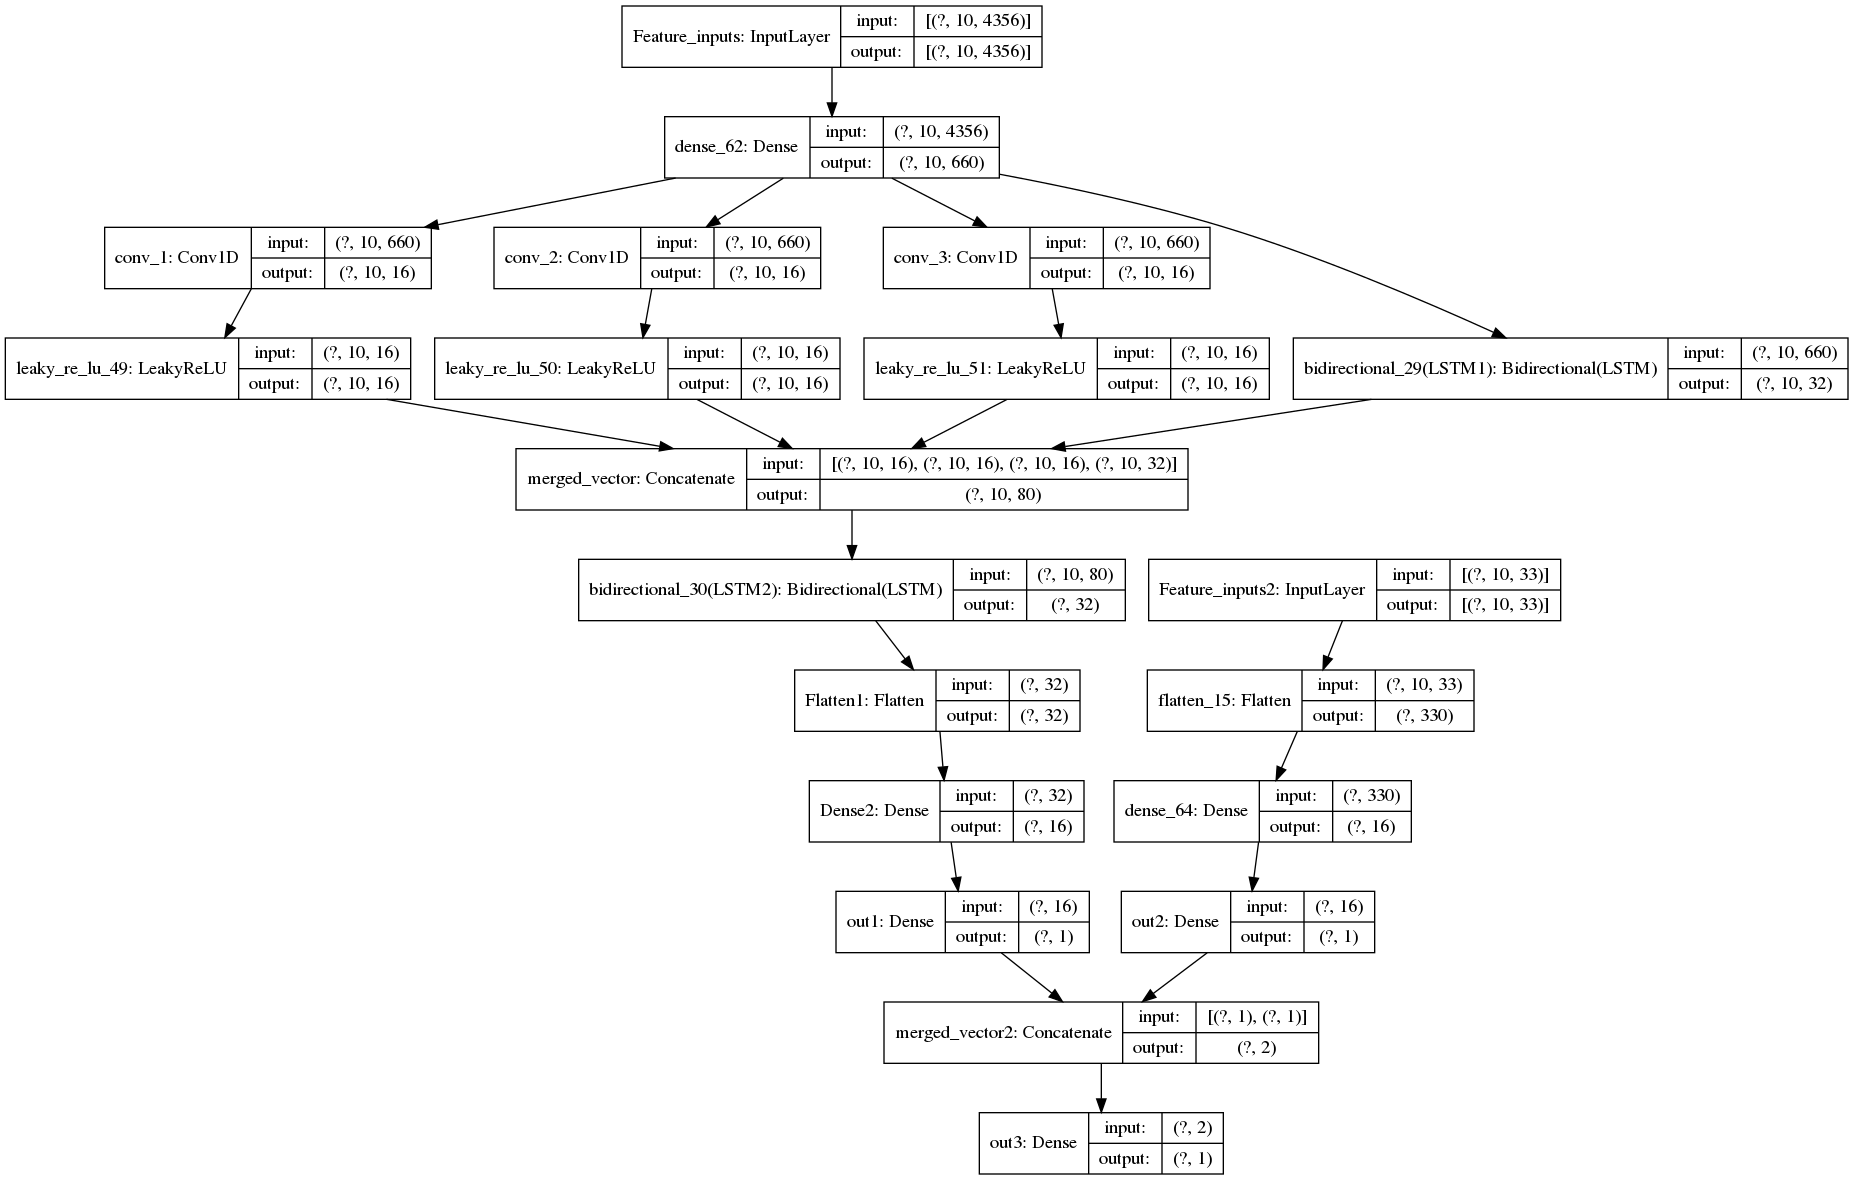

In [44]:
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow as tf
# from spektral.layers import GraphConv
from tensorflow.keras.models import Model # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers


def build_model(input_seq_len=132, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam'
               ):
        
    # inputs
    Feature_inputs = L.Input(shape=(input_seq_len, 4356), name="Feature_inputs")
    Feature_inputs2 = L.Input(shape=(input_seq_len, 33), name="Feature_inputs2")

    Feature_inputs_new = L.Dense(660)(Feature_inputs)
    Feature_inputs_new2 = L.Dense(64)(Feature_inputs2)

    conv_1 = L.Conv1D(
        16, 1,
        padding='same',name="conv_1")(Feature_inputs_new)
    conv_1_1 = L.LeakyReLU()(conv_1)

    conv_2 = L.Conv1D(
        16,3,
        padding='same',name="conv_2")(Feature_inputs_new)
    conv_2_2 = L.LeakyReLU()(conv_2)

    
    conv_3 = L.Conv1D(
        16,4,
        padding='same',name="conv_3")(Feature_inputs_new)
    conv_3_3 = L.LeakyReLU()(conv_3)



    LSTM1 = L.Bidirectional(LSTM(16,input_shape=(input_seq_len,660),return_sequences=True,name='LSTM1'))(Feature_inputs_new)
    
    merged_vector = concatenate([conv_1_1, conv_2_2, conv_3_3, LSTM1], axis=-1,name="merged_vector")
    LSTM2 = L.Bidirectional(LSTM(16,name='LSTM2'))(merged_vector)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten1)
    out1 = Dense(1, activation='sigmoid',name="out1")(Dense2)
    
    Flatten2 = Flatten()(Feature_inputs2)
    Dense2 = Dense(16)(Flatten2)
    out2 = Dense(1,name='out2')(Dense2)
    
    merged_vector2 = concatenate([out1, out2], axis=-1,name="merged_vector2")
    out3 = Dense(1, activation='sigmoid',name="out3")(merged_vector2)
    
    model = Model(
        inputs=[
            Feature_inputs,Feature_inputs2
        ],
        outputs=out3,
    )
    model.compile(loss=losss,
                  optimizer=optimizerr,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    return model

model = build_model(input_seq_len=10, 
                output_seq_len=64,
                losss='mse',
                optimizerr='adam')
tf.keras.utils.plot_model(model,to_file='1.png',show_shapes=True,show_layer_names=True)   

In [1]:

import numpy as np
# 关闭新版numpy的警告
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

import random
import math
import os
import scipy.io
from scipy.io import loadmat
import scipy
from datetime import datetime
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
print(tf.__version__)
from tensorflow.keras import * 
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))   #打印gpu信息
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"


1.15.0
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [2]:
# data
# https://github.com/XiuzeZhou/NASA/blob/main/RNN%20%26%20LSTM.ipynb

# 转换时间格式，将字符串转换成 datatime 格式
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)

# 加载 mat 文件
def loadMat(matfile):
    data = scipy.io.loadmat(matfile)  # 加载mat文件
    filename = matfile.split("/")[-1].split(".")[0]  # 以‘.’和‘/’为分隔符分割，分割出路径中的文件名
            # nasa_count_data/B0006.mat  ---》  B0006
    col = data[filename]  # dict_keys(['__header__', '__version__', '__globals__', 'B0006'])
    col = col[0][0][0][0]  # numpy   (1, 1 )  --->  (616,)  
    size = col.shape[0]

    data = []
    for i in range(size):
#         print(col.shape)
        k = list(col[i][3][0].dtype.fields.keys()) 
        # k:dict_keys(['Voltage_measured', 'Current_measured', 'Temperature_measured', 
                        #'Current_charge', 'Voltage_charge', 'Time'])
        # “电压测量”、“电流测量”、“温度测量”、“电流充电”、“电压充电”、“时间”
        # col[i][0][0]  : 表示当前样本i的作业类别，放电、充电、阻抗
        # col[i][1][0]  : 表示当前样本i的作业温度
        # col[i][2][0]  : 表示当前样本i的作业日期，时间，'2008-04-02 13:08:17'
        # col[i][3][0]  : 表示当前样本i的作业六个参数值
        
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance': # 判断作业类型,非阻抗作业
            for j in range(len(k)):          # 遍历六个特征列
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l                 # 将读取到的数据放入对应的字典keys下
        d1['type'], d1['temp'] = str(col[i][0][0]), int(col[i][1][0])
        d1['time'], d1['data'] = str(convert_to_time(col[i][2][0])), d2
        data.append(d1)
    return data

# 提取锂电池容量
def getBatteryCapacity(Battery):
    # 电池容量在放电数据集 'discharge'的'Capacity'特征下；
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]  # 构成了(x, y)坐标系


# 获取锂电池充电或放电时的测试数据
def getBatteryValues(Battery, Type='charge'):
    data=[]
    for Bat in Battery:
        if Bat['type'] == Type:
            data.append(Bat['data'])
    return data

# 检查样本列表中个样本的数据量
def samples_nums(Battery_list,dir_path,filetype='.mat'):
    for name in Battery_list:
        path = dir_path + name + filetype
        data = loadMat(path)
        python_y=np.array(data) #将matlab数据赋值给python变量
        c, d, im = 0, 0, 0
        for i in range(0,len(python_y)):
            if python_y[i]['type']=='charge': c+=1
            if python_y[i]['type']=='discharge': d+=1
            if python_y[i]['type']=='impedance': im+=1
        print('样本%s，总样本数：'%name,python_y.shape[0],
              '， 冲电记录次数：',c,'， 放电记录次数：',d,'， 阻抗记录次数：',im)

# 获取列表样本对应的电池数据     
def Battery_Data(Battery_list,dir_path):
    capacity, charge, discharge = {}, {}, {}
    for name in Battery_list:
        print('Load Dataset ' + name + '.mat ...')
        path = dir_path + name + '.mat'
        data = loadMat(path)
        print(len(data))
        capacity[name] = getBatteryCapacity(data)              # 放电时的容量数据
        charge[name] = getBatteryValues(data, 'charge')        # 充电数据
        discharge[name] = getBatteryValues(data, 'discharge')  # 放电数据
    return capacity, charge, discharge

# 作图，同样本数据对比图
def plot_Comparison(samples_name, data, list_name, color_list,x_ax=None,y_ax=None, unit=None, label=None):
    if samples_name!=None:
        # 单样本数据画图比对
        fig, ax = plt.subplots(1, figsize=(12, 8))
        c = 0
        for t,color in zip(list_name, color_list):
            Battery = data[samples_name][t]
            ax.plot(Battery[x_ax], Battery[y_ax], color, label='%s time: '%label+str(t))
            c += 1
        ax.set(xlabel=x_ax, ylabel=y_ax.split("_")[0] + ' (%s)'%unit, title='%s Curve'%label)
        plt.legend()
    plt.savefig('NASA-05-018-%s-%s.png'%(label,y_ax.split("_")[0]))

    
# 求两特征相关性系数--Pearson
# 要求输入为numpy数组
def cal_pccs(x, y, n):
    """
    warning: data format must be narray
    :param x: Variable 1
    :param y: The variable 2
    :param n: The number of elements in x
    :return: pccs
    """
    sum_xy = np.sum(np.sum(x*y))
    sum_x = np.sum(np.sum(x))
    sum_y = np.sum(np.sum(y))
    sum_x2 = np.sum(np.sum(x*x))
    sum_y2 = np.sum(np.sum(y*y))
    pcc = (n*sum_xy-sum_x*sum_y)/np.sqrt((n*sum_x2-sum_x*sum_x)*(n*sum_y2-sum_y*sum_y))
    return pcc

def Compute_Pearson(Battery_list1,i,polt=True):
    # 查看电池特征相关系数
    # 目标数据
    name = Battery_list1[i]       #查看的电池号
    indexx = len(discharge[name])
    # 数据生成
    d_V = []
    d_C = []
    d_T = []
    d_CUR = []
    for i in range(0,indexx):
        v=np.array(discharge[name][i]['Voltage_measured'][:])
        t = np.array(discharge[name][i]['Temperature_measured'][:])
        cur = np.array(charge[name][i]['Current_measured'][:])
        c = np.array(discharge[name][i]['Capacity'])

        d_V.append(np.mean(v))
        d_T.append(np.mean(t))
        d_CUR.append(np.mean(cur))
        d_C.append(c)   
    V = np.array(d_V).reshape(-1,1)
    T = np.array(d_T).reshape(-1,1)
    CUR = np.array(d_CUR).reshape(-1,1)
    C = np.array(d_C)
    # 数据归一化
    CC, _ = np.array(Fit_transform(C,0,1))
    VV, _ = np.array(Fit_transform(V,0,1))
    CURR, _ = np.array(Fit_transform(CUR,0,1))
    TT, _ = np.array(Fit_transform(T,0,1))
    # 制图
    if polt==True:    
        plt.figure(figsize=(12, 8))
        plt.plot(VV,label='Voltage_measured')
        plt.plot(CURR,label='Current_measured')
        plt.plot(CC,label='Capacity')
        plt.plot(TT,label='Temperature_measured')
        plt.legend()
        plt.show()
    # 计算Pearson
    pccs_C_V = cal_pccs(CC,VV,CC.shape[0])
    pccs_C_T = cal_pccs(CC,TT,CC.shape[0])
    pccs_C_CUR = cal_pccs(CC,CURR,CC.shape[0])
    pccs_CUR_V = cal_pccs(CURR,VV,CURR.shape[0])

#     print('相关特征的Pearson系数（时序特征取均值）：')
#     print('  容量--放电电压:',pccs_C_V,'\n  容量--温度: ',pccs_C_T,'\n  容量--充电电流: ',pccs_C_CUR,'\n  充电电流--放电电压： ',pccs_CUR_V)
    return name, pccs_C_V, pccs_C_T, pccs_C_CUR, pccs_CUR_V

In [3]:
# 路径，样本列表
dir_path = "nasa_count_data/"
Battery_list0 = [
                'B0005', 'B0006', 'B0007', 'B0018',
#                'B0025', 'B0026', 'B0027', 'B0028',   # 差
#                'B0029', 'B0030', 'B0031', 'B0032',     # C-CUR
#                'B0033', 'B0034', 'B0036', 'B0038',     # 差
#                'B0039', 'B0040', 'B0041', 'B0042',     # C_T
#                'B0043', 'B0044', 'B0045', 'B0046',      # C_T
#                'B0047', 'B0048', 'B0049', 
#                'B0050',
#                'B0051',
#                'B0052', 
#                 'B0053', 'B0054',
#                'B0055', 'B0056'
                ]
# Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']

# Battery_list1 = ['B0055']


# 检查数据个数，获取样本电池数据
# samples_nums(Battery_list0,dir_path,'.mat')     
capacity, charge, discharge = Battery_Data(Battery_list0,dir_path)

Load Dataset B0005.mat ...
616
Load Dataset B0006.mat ...
616
Load Dataset B0007.mat ...
616
Load Dataset B0018.mat ...
319


In [4]:
# 检查数据时序数
# for i in range(0,len(discharge['B0005'])):
#     print(len(discharge['B0005'][i]['Voltage_measured']))
low = 1000
for name in Battery_list0:
#     print(len(discharge[name]))
    xxx = discharge[name]
    for i in range(0,len(xxx)):
#         print(len(xxx[i]['Voltage_measured']))
        if len(xxx[i]['Voltage_measured'])<low: low=len(xxx[i]['Voltage_measured'])
    print(low)
print(low)

179
179
179
179
179


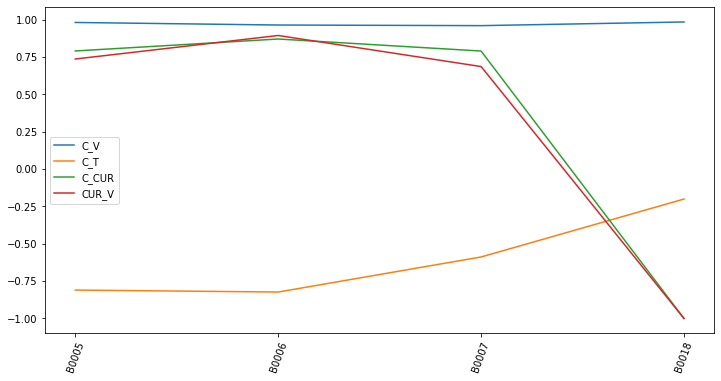

0.9735530380506845 -0.6051713026607615 0.8179667109239808 0.7732100536482336


In [228]:


# bat_name, pccs_C_V, pccs_C_T, pccs_C_CUR, pccs_CUR_V = Compute_Pearson(Battery_list1,0,polt=False)
# print('# 样本%s相关特征的Pearson系数（时序特征取均值）：'%bat_name)
# print('#   容量--放电电压:',pccs_C_V,'\n#   容量--温度: ',pccs_C_T,'\n#   容量--充电电流: ',pccs_C_CUR,'\n#   充电电流--放电电压： ',pccs_CUR_V)

bat_name0, pccs_C_V0, pccs_C_T0, pccs_C_CUR0, pccs_CUR_V0 = [], [], [], [], []
for i in range(0,len(Battery_list0)):
    bat_name, pccs_C_V, pccs_C_T, pccs_C_CUR, pccs_CUR_V = Compute_Pearson(Battery_list0,i,polt=False)
#     print('# 样本%s相关特征的Pearson系数（时序特征取均值）：'%bat_name)
#     print('#   容量--放电电压:',pccs_C_V,'\n#   容量--温度: ',pccs_C_T,'\n#   容量--充电电流: ',pccs_C_CUR,'\n#   充电电流--放电电压： ',pccs_CUR_V)

    bat_name0.append(bat_name)
    pccs_C_V0.append(pccs_C_V)
    pccs_C_T0.append(pccs_C_T)
    pccs_C_CUR0.append(pccs_C_CUR)
    pccs_CUR_V0.append(pccs_CUR_V)
    
# 替换掉数据中的NaN为-1
# 转换numpy数组
pccs_C_V0 = np.array(pccs_C_V0)
pccs_C_T0 = np.array(pccs_C_T0)
pccs_C_CUR0 = np.array(pccs_C_CUR0)
pccs_CUR_V0 = np.array(pccs_CUR_V0)
# 提出NaN
pccs_C_V0[np.isnan(pccs_C_V0)]=-1
pccs_C_T0[np.isnan(pccs_C_T0)]=-1
pccs_C_CUR0[np.isnan(pccs_C_CUR0)]=-1
pccs_CUR_V0[np.isnan(pccs_CUR_V0)]=-1
# 作图
plt.figure(figsize=(12,6))
plt.plot(bat_name0,pccs_C_V0,label='C_V')
plt.plot(bat_name0,pccs_C_T0,label='C_T')
plt.plot(bat_name0,pccs_C_CUR0,label='C_CUR')
plt.plot(bat_name0,pccs_CUR_V0,label='CUR_V')
plt.xticks(bat_name0, rotation=70)
plt.legend()
plt.show()
# 提出指数为-1的异常样本求均值
pccs_C_V00 = pccs_C_V0[~np.isin(pccs_C_V0,-1)] # 提取
pccs_C_T00 = pccs_C_T0[~np.isin(pccs_C_T0,-1)] # 提取
pccs_C_CUR00 = pccs_C_CUR0[~np.isin(pccs_C_CUR0,-1)] # 提取
pccs_CUR_V00 = pccs_CUR_V0[~np.isin(pccs_CUR_V0,-1)] # 提取

print(np.mean(pccs_C_V00),
      np.mean(pccs_C_T00),
      np.mean(pccs_C_CUR00),
      np.mean(pccs_CUR_V00),
     )
# print(pccs_C_CUR0)
# B0007
#   容量--放电电压: 0.9610706209036669 
#   容量--温度:  -0.5879941035824494 
#   容量--充电电流:  0.7909424324750002 
#   充电电流--放电电压：  0.6870478977700829

# B0006
#   容量--放电电压: 0.9651892617740581 
#   容量--温度:  -0.8228777392033562 
#   容量--充电电流:  0.8715113841070898 
#   充电电流--放电电压：  0.8950813199565472

# B0005
# 相关特征的Pearson系数（时序特征取均值）：
#   容量--放电电压: 0.9823573584005616 
#   容量--温度:  -0.8097441885175439 
#   容量--充电电流:  0.7914463161898525 
#   充电电流--放电电压：  0.7375009432180707

# 样本B0026相关特征的Pearson系数（时序特征取均值）：
#   容量--放电电压: 0.7984215765521347 
#   容量--温度:  0.5523353080722812 
#   容量--充电电流:  0.030034132174580997 
#   充电电流--放电电压：  -0.03566458544547508

# 样本B0030相关特征的Pearson系数（时序特征取均值）：
#   容量--放电电压: -0.23032070720836664 
#   容量--温度:  -0.2770492598672758 
#   容量--充电电流:  0.9030163861658413 
#   充电电流--放电电压：  -0.3828330523270727

# # 样本B0045相关特征的Pearson系数（时序特征取均值）：
#   容量--放电电压: -0.07743996113466108 
#   容量--温度:  0.09449516646704798 
#   容量--充电电流:  0.8142465294976838 
#   充电电流--放电电压：  0.15659984527726917



168
7


IndexError: list index out of range

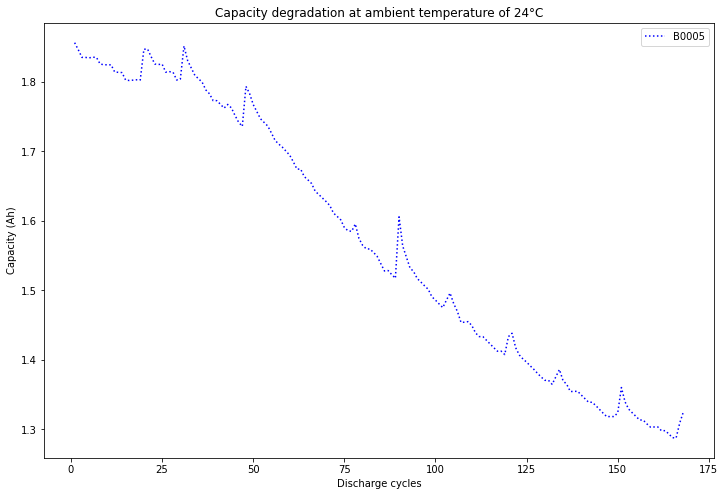

In [259]:
# 3. 容量 v.s. 充放电次数 曲线


fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:']#, 'g--', 'r-.', 'c+']
c = 0
for name,color in zip(Battery_list0, color_list):
    df_result = capacity[name]  # （循环次数， 当前容量）坐标
    print(len(df_result[0]))
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()
# plt.savefig('NASA-05-018-Capacity.png')

# 4. 充电电流 v.s. 充电时间 曲线
name = Battery_list0[0]       #查看的电池号
time = [0, 50, 100, 150] #查看的充电次数
color_list = ['b']#, 'g', 'r', 'c']

print(len(discharge[name][0]))
print(capacity[name][2]['Capacity'])

plot_Comparison(samples_name=name, data=charge, 
                list_name=time, color_list=color_list, 
                x_ax='Time', y_ax='Current_measured', unit='A', label='Charging')
# 5. 放电电压 v.s. 充电时间 曲线
time_d = [0, 50, 100, 150]     #查看的放电次数
color_list_d = ['b']#, 'g', 'r', 'c']
plot_Comparison(samples_name=name, data=discharge, 
                list_name=time_d, color_list=color_list_d, 
                x_ax='Time', y_ax='Voltage_measured', unit='V',label='Discharging')

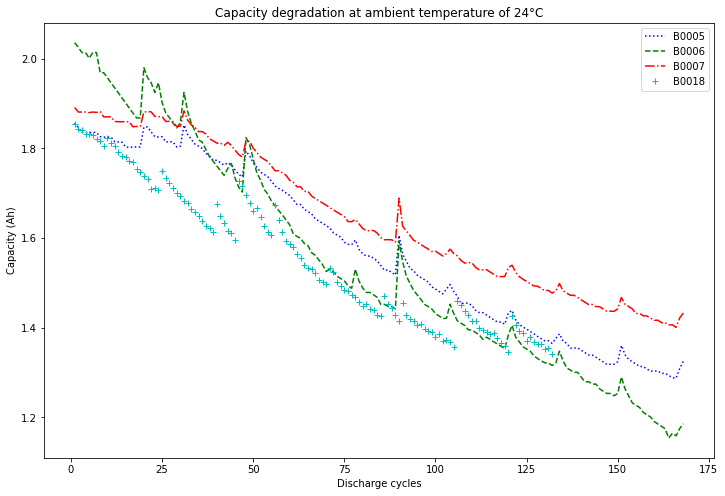

In [5]:
# 3. 容量 v.s. 充放电次数 曲线


fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c+']
c = 0
for name,color in zip(Battery_list, color_list):
    df_result = capacity[name]  # （循环次数， 当前容量）坐标
    ax.plot(df_result[0], df_result[1], color, label=name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
plt.legend()
plt.savefig('NASA-05-018-Capacity.png')


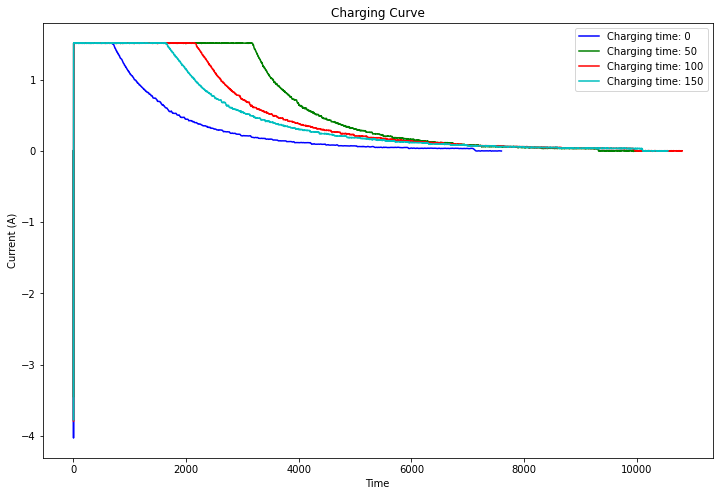

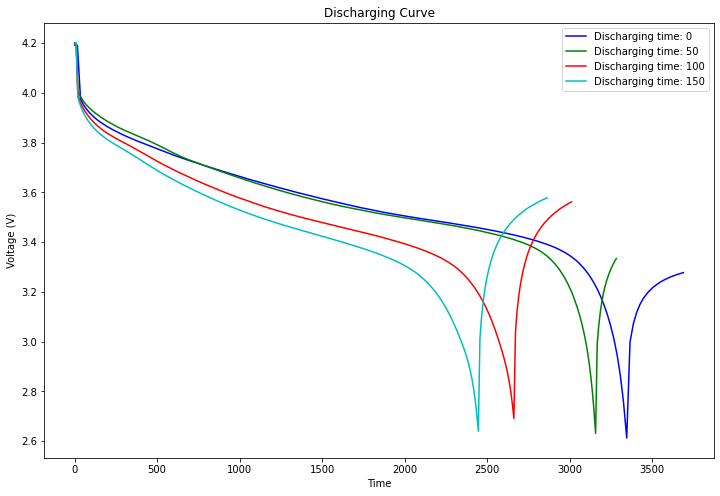

In [6]:
# 4. 充电电流 v.s. 充电时间 曲线
name = 'B0005'       #查看的电池号
time = [0, 50, 100, 150] #查看的充电次数
color_list = ['b', 'g', 'r', 'c']
plot_Comparison(samples_name=name, data=charge, 
                list_name=time, color_list=color_list, 
                x_ax='Time', y_ax='Current_measured', unit='A', label='Charging')
# 5. 放电电压 v.s. 充电时间 曲线
time_d = [0, 50, 100, 150]     #查看的放电次数
color_list_d = ['b', 'g', 'r', 'c']
plot_Comparison(samples_name=name, data=discharge, 
                list_name=time_d, color_list=color_list_d, 
                x_ax='Time', y_ax='Voltage_measured', unit='V',label='Discharging')


In [5]:
# 数据集打包模块
# 打包当前sheet序列数据和标签
# 重叠打包策略
def createXY(dataset,n_past):
    """
        dataset：传入数据集；
        n_past：lstm的timestep，预测下一个目标值时将在过去查看的步骤数；
        index: 预测目标标签；
        trainX — — →trainY
        eg：
            [0 : 30,0:5] → [30,0]
            [1:31, 0:5] → [31,0]
            [2:32,0:5] →[32,0]
    """
#     print(dataset.shape,dataset.shape[1])
    n_past=int(n_past)
#     index=int(index)
    dataX = [] # 所有的特征值
    dataY = [] # 目标预测标签

#     print(len(dataset),dataset[168])
    for i in range(n_past, len(dataset)):
#         print()
        if i<len(dataset):
            dataX.append(dataset[i - n_past:i])
            dataY.append(dataset[i])
        else:
            break
    return np.array(dataX),np.array(dataY)


def build_sequences(text, window_size):
    # 
    x, y = [],[]
    for i in range(window_size,len(text)):  # 【window_size:-1】
        if i<len(text):
            sequence = text[i - window_size:i]      # 特征
            target = text[i]    # 标签,延后的序列。。。？？？

            x.append(sequence)
            y.append(target)
        else:
            break
        
    return np.array(x), np.array(y)

def get_train_test(data_dict, window_size=8, test_num=20):
    # 原始数据， 时序窗口， 测试几个数
    x, y, x_test, y_test = [], [], [], []
    count = 0
    for k, v in data_dict.items():  # 返回可遍历的(键, 值) 元组数组，然后便利， k:样本名， v:样本对应数据（容量）
        data_x, data_y = build_sequences(text=v[1], window_size=window_size)
        data_x0, data_y0 = data_x[0:-test_num], data_y[0:-test_num]
        data_x1, data_y1 = data_x[-test_num:], data_y[-test_num:]
        if count==0:
            x, y = data_x0, data_y0
            x_test, y_test = data_x1, data_y1
        else:
            x, y = np.r_[x, data_x0], np.r_[y, data_y0]
            x_test, y_test = np.r_[x_test, data_x1], np.r_[y_test, data_y1]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
        count+=1
    return x, y, x_test, y_test

def get_train_test_2(data_dict_1, list_name, feature_name=None, label_name=None, window_size=8, test_rat=0.2):
    # 输入： 原始数据[1,2]，样本列表，特征名，标签名， 时序窗口， 测试集比例
    # 输出： 划分好的训练集测试集
    # 样本最短时序179
    x, y, x_test, y_test = [], [], [], []
    data_x, data_y = [], []
    count = 0
    # 所有数据读取出来
    for name in list_name:
        data_1 = data_dict_1[name]
#         data_2 = data_dict_2[name]
        # 特征
        for i in range(0,len(data_1)):
            data_x.append(np.array(data_1[i][feature_name][-window_size:]))
            data_y.append(np.array(data_1[i][label_name]))
#         print(np.array(data_1).shape)
#         print('111111',np.array(data_x).shape,np.array(data_y).shape)
    # 划分数据集，尾部20%为预测样本
    test_nums = int(round(len(data_y)*test_rat))  # 注意取整
    x = np.array(data_x[0:-test_nums])
    y = np.array(data_y[0:-test_nums])
    x_test = np.array(data_x[-test_nums:])
    y_test = np.array(data_y[-test_nums:])
    print('训练集特征：',x.shape,', 训练集标签：',y.shape,
          ';\n测试集特征：',x_test.shape,', 测试集标签：',y_test.shape,
         '; \n总数据量：',np.array(data_x).shape,np.array(data_y).shape)
    return x, y, x_test, y_test

def shuffle_data(X,y):
    # shuffle数据集
    # X,y: 数据集样本和标签
    # return：shuffle后的特征和标签，以及打乱后的索引
    data_list=np.array(X)           # list of images
    label_list=np.array(y)           # list of labels

    ##如果image_list存的是读取的特征数据，而不是图片路径，不要注释后面两句（list无法索引内部list）
    #[list indices must be integers or slices, not list]
    #image_list = np.array(image_list)
    #label_list = np.array(label_list)

    index = [i for i in range(len(data_list))]
    np.random.shuffle(index)
    data = data_list[index]
    labels = label_list[index]
    return data, labels, index

# 获取所有样本列元素极值，用于归一化尺度
# def sheet_extreme(data,sheet_nums,category='regression'):
    
    
# 多维根据normalize归一化Positive / 反归一化negative
def NormalizeMult_1(data,normalize, type='Positive'):
    # 数据， 极值列表
    data = np.array(data)
    listlow = normalize[0][0]
    listhigh = normalize[0][1]
    delta = listhigh - listlow
    for i in range(0,data.shape[0]):
        if delta != 0:
            if type=='Positive':
                    data[i]  =  (data[i] - listlow)/delta                  
            elif type=='Negative':
                    data[i]  =  data[i]*delta + listlow
                    
    
    
    
#     for i in range(0,data.shape[1]):
#         listlow = normalize[i,0]
#         listhigh = normalize[i,1]
#         delta = listhigh - listlow
#         if delta != 0:
#             for j in range(0,data.shape[0]):
#                 if type=='Positive':
#                     data[j,i]  =  (data[j,i] - listlow)/delta                  
#                 elif type=='Negative':
#                     data[j,i]  =  data[j,i]*delta + listlow
    return  data


# 获取所有样本列元素极值，用于归一化尺度
def sheet_extreme(data,category='1'):
    
    # 声明一个初始化极值标签列表，取自样本
    if  category=='4':
        normalize_end = np.array( [[4.5358, 9.3226],
                                 [0.0000, 1.6654],
                                 [4.8653, 1.0000],
                                 [0.0000, 1.0000]])
    elif category=='3':
        normalize_end = np.array( [[4.5358, 9.3226],
                                  [0.0000, 1.6654],
                                  [0.0000, 1.6654]])         
    elif category=='2':
        normalize_end = np.array( [[4.5358, 9.3226],
                                 [0.0000, 1.6654]])  
    elif category=='1':
        normalize_end = np.array( [[4.5358, 9.3226]])  
        
    for i in range(0,data.shape[1]): # 遍历列
        #第i列数据
        listt = data[:,i]
        # 获得目标列极值
        listlow,listhigh =  np.percentile(listt, [0, 100])
        # 存储目标列极值
        normalize_end[i,0] = listlow
        normalize_end[i,1] = listhigh
    print('end_normalize:\n',normalize_end)
    return normalize_end
        
from functools import partial
def flatten(x):
    # 上面这个 flatten 函数有两个返回值，一个是拉平后的 1 维数组，第二个是恢复原来形状的函数
    # a2,unflatten = flatten(a1), unflatten(a2) = a1
    original_shape = x.shape
    return x.flatten(), partial(np.reshape, newshape=original_shape)


from sklearn.preprocessing import MinMaxScaler
# 数据归一化
def Fit_transform(raw_data,a,b):
    # 数据归一化
    scaler = MinMaxScaler(feature_range=(a, b))
    return scaler.fit_transform(raw_data), scaler
def Inverse_transform(raw_data,scaler):
    # 将标准化后的数据转换为原始数据（反归一化）
    return scaler.inverse_transform(raw_data)  



In [6]:
    train_x111, train_y111, test_x111, test_y111 = get_train_test_2(discharge, Battery_list0, 
                                                            feature_name='Voltage_measured', 
                                                            label_name='Capacity', 
                                                            window_size=170, test_rat=0.2)

训练集特征： (509, 170) , 训练集标签： (509, 1) ;
测试集特征： (127, 170) , 测试集标签： (127, 1) ; 
总数据量： (636, 170) (636, 1)


In [7]:
# CNN1D模型三特征
def build_model_cnn1d(optimizer,data_size):
    input_data_full = Input(shape=data_size, name='input_data_full')
    # 1分支
    cnn_out = Conv1D(filters=64, kernel_size=8, 
                     activation='relu',padding='same', input_shape=data_size,name="cnn_out")(input_data_full)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(50, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = 'CNN1D'
    return model,x

# LSTM
def build_model_LSTM(optimizer, data_size):
    input_data_full = Input(shape=data_size, name='input_data_full')
    LSTM1 = LSTM(64,input_shape=data_size,return_sequences=True,name='LSTM1')(input_data_full)
    LSTM2 = LSTM(64,name='LSTM2')(LSTM1)
    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer=optimizer,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'LSTM2'
    return model,x
def build_model_LSTM1(optimizer, data_size):
    input_data_full = Input(shape=data_size, name='input_data_full')
    LSTM1 = LSTM(64,input_shape=data_size,return_sequences=True,name='LSTM1')(input_data_full)
    Flatten1 = Flatten(name="Flatten1")(LSTM1)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer=optimizer,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'LSTM1'
    return model,x

# GRU
def build_model_GRU(optimizer, data_size):
    input_data_full = Input(shape=data_size, name='input_data_full')
    GRU1 = GRU(16,input_shape=data_size,return_sequences=True,name='GRU1')(input_data_full)
    GRU2 = GRU(16,return_sequences=True,name='GRU2')(GRU1)
    GRU3 = GRU(16,name='GRU3')(GRU2)
    Flatten1 = Flatten(name="Flatten1")(GRU3)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Flatten1)
    inputs = [input_data_full]
    model = Model(inputs, predictions1)  ####    
    model.compile(loss='mse',
                  optimizer=optimizer,
#                   optimizer=optimizers.Adam(lr=0.004,decay=0.04), 
                  metrics=['accuracy'])
    model.summary()
    x = 'GRU3'
    return model,x

def build_model_CNN_LR(optimizer, data_size):
    # 定义输入
    input_data_sm = Input(shape=data_size, name='input_data_sm')
    input_data_wh_V = Input(shape=data_size, name='input_data_wh_V')
    # LR分支
    Flatten1 = Flatten(name="Flatten1")(input_data_sm)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
    # CNN分支
    cnn_out = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out")(input_data_wh_V)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    # 合并向量：
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
    Dense3 = Dense(16, activation='sigmoid',name="Dense3")(merged_vector)
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)
    inputs = [input_data_sm,input_data_wh_V]
    model = Model(inputs, predictions2)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "CNN1D_LR"
    return model,x

def build_model_CNN_CNN(optimizer, data_size):
    # 定义输入
    input_data_sm = Input(shape=data_size, name='input_data_sm')
    input_data_wh_V = Input(shape=data_size, name='input_data_wh_V')
    # CNN-1分支
    cnn_out0 = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out0")(input_data_sm)
    Flatten1 = Flatten(name="Flatten1")(cnn_out0)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
    # CNN-2分支
    cnn_out = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out")(input_data_wh_V)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    # 合并向量：
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
    Dense3 = Dense(16, activation='sigmoid',name="Dense3")(merged_vector)
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)
    inputs = [input_data_sm,input_data_wh_V]
    model = Model(inputs, predictions2)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "CNN1D_CNN1D"
    return model,x

def build_model_CNN_LSTM(optimizer, data_size):
    # 定义输入
    input_data_1 = Input(shape=data_size, name='input_data_sm')
    input_data_2 = Input(shape=data_size, name='input_data_wh_V')
    # CNN-1分支
    LSTM1 = LSTM(64,input_shape=data_size,return_sequences=True,name='LSTM1')(input_data_1)
    Flatten1 = Flatten(name="Flatten1")(LSTM1)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
    # CNN-2分支
    cnn_out = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out")(input_data_2)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    # 合并向量：
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
    Dense3 = Dense(16, activation='sigmoid',name="Dense3")(merged_vector)
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)
    inputs = [input_data_1,input_data_2]
    model = Model(inputs, predictions2)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "CNN1D_LSTM1"
    return model,x

def build_model_CNN_GRU(optimizer, data_size):
    # 定义输入
    input_data_1 = Input(shape=data_size, name='input_data_sm')
    input_data_2 = Input(shape=data_size, name='input_data_wh_V')
    # CNN-1分支
    GRU1 = GRU(64,input_shape=data_size,return_sequences=True,name='GRU1')(input_data_1)
    Flatten1 = Flatten(name="Flatten1")(GRU1)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
    # CNN-2分支
    cnn_out = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out")(input_data_2)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    # 合并向量：
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
    Dense3 = Dense(16, activation='sigmoid',name="Dense3")(merged_vector)
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)
    inputs = [input_data_1,input_data_2]
    model = Model(inputs, predictions2)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "CNN1D_GRU1"
    return model,x

def build_model_CNN_LSTM2(optimizer,data_size):
    # 定义输入
    input_data_1 = Input(shape=data_size, name='input_data_sm')
    input_data_2 = Input(shape=data_size, name='input_data_wh_V')
    # CNN-1分支
    LSTM1 = LSTM(64,input_shape=data_size,return_sequences=True,name='LSTM1')(input_data_1)
    LSTM2 = LSTM(64,name='LSTM2')(LSTM1)

    Flatten1 = Flatten(name="Flatten1")(LSTM2)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
    # CNN-2分支
    cnn_out = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out")(input_data_2)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    # 合并向量：
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
    Dense3 = Dense(16, activation='sigmoid',name="Dense3")(merged_vector)
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)
    inputs = [input_data_1,input_data_2]
    model = Model(inputs, predictions2)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "CNN1D_LSTM2"
    return model,x

def build_model_CNN_GRU2(optimizer,data_size):
    # 定义输入
    input_data_1 = Input(shape=data_size, name='input_data_sm')
    input_data_2 = Input(shape=data_size, name='input_data_wh_V')
    # CNN-1分支
    GRU1 = GRU(64,input_shape=data_size,return_sequences=True,name='GRU1')(input_data_1)
    GRU2 = GRU(64,name='GRU2')(GRU1)

    Flatten1 = Flatten(name="Flatten1")(GRU2)
    predictions0 = Dense(1, activation='sigmoid',name="predictions0")(Flatten1)
    # CNN-2分支
    cnn_out = Conv1D(filters=16, kernel_size=8, activation='relu',padding='same', 
                     input_shape=data_size,name="cnn_out")(input_data_2)
    Flatten2 = Flatten(name="Flatten2")(cnn_out)
    Dense2 = Dense(16, activation='sigmoid',name="Dense2")(Flatten2)
    predictions1 = Dense(1, activation='sigmoid',name="predictions1")(Dense2)
    # 合并向量：
    merged_vector = concatenate([predictions0, predictions1], axis=-1,name="merged_vector")
    Dense3 = Dense(16, activation='sigmoid',name="Dense3")(merged_vector)
    predictions2 = Dense(1, activation='sigmoid',name="predictions2")(Dense3)
    inputs = [input_data_1,input_data_2]
    model = Model(inputs, predictions2)  
    model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])
    model.summary()
    x = "CNN1D_GRU2"
    return model,x

训练集特征： (509, 170) , 训练集标签： (509, 1) ;
测试集特征： (127, 170) , 测试集标签： (127, 1) ; 
总数据量： (636, 170) (636, 1)
(509, 170, 1) (509, 1) (127, 170, 1) (127, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_data_wh_V (InputLayer)    [(None, 170, 1)]     0                                            
__________________________________________________________________________________________________
input_data_sm (InputLayer)      [(None, 170, 1)]     0                                            
__________________________________________________________________________________________________
cnn_out (Conv1D)                (None, 170, 16)      144         input_data_wh_V[0][0]            
__________________________________________________________________________________________________
GRU1 (GRU)                      (None, 170

504/509 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.0040
Epoch 00017: loss improved from 0.02622 to 0.02199, saving model to ./test1/model_CNN1D_GRU1_170-1_2.hdf5
509/509 [==============================] - 2s 5ms/sample - loss: 0.0220 - acc: 0.0039 - val_loss: 0.0490 - val_acc: 0.0157
Epoch 18/600
504/509 [============================>.] - ETA: 0s - loss: 0.0179 - acc: 0.0040
Epoch 00018: loss improved from 0.02199 to 0.01804, saving model to ./test1/model_CNN1D_GRU1_170-1_2.hdf5
509/509 [==============================] - 2s 5ms/sample - loss: 0.0180 - acc: 0.0039 - val_loss: 0.0448 - val_acc: 0.0157
Epoch 19/600
504/509 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.0040
Epoch 00019: loss improved from 0.01804 to 0.01531, saving model to ./test1/model_CNN1D_GRU1_170-1_2.hdf5
509/509 [==============================] - 2s 5ms/sample - loss: 0.0153 - acc: 0.0039 - val_loss: 0.0406 - val_acc: 0.0157
Epoch 20/600
504/509 [=========================

504/509 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.0040  
Epoch 00043: loss did not improve from 0.00204
509/509 [==============================] - 2s 5ms/sample - loss: 0.0021 - acc: 0.0039 - val_loss: 0.0112 - val_acc: 0.0157
Epoch 44/600
504/509 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.0040
Epoch 00044: loss did not improve from 0.00204
509/509 [==============================] - 2s 5ms/sample - loss: 0.0021 - acc: 0.0039 - val_loss: 0.0114 - val_acc: 0.0157
Epoch 45/600
504/509 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.0040
Epoch 00045: loss did not improve from 0.00204
509/509 [==============================] - 2s 5ms/sample - loss: 0.0021 - acc: 0.0039 - val_loss: 0.0112 - val_acc: 0.0157
Epoch 46/600
504/509 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.0040
Epoch 00046: loss did not improve from 0.00204
509/509 [==============================] - 2s 5ms/sample - loss: 0.0021 - acc: 0.0

504/509 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.0040
Epoch 00072: loss did not improve from 0.00152
509/509 [==============================] - 2s 5ms/sample - loss: 0.0016 - acc: 0.0039 - val_loss: 0.0126 - val_acc: 0.0157
Epoch 73/600
504/509 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0040
Epoch 00073: loss improved from 0.00152 to 0.00149, saving model to ./test1/model_CNN1D_GRU1_170-1_2.hdf5
509/509 [==============================] - 2s 5ms/sample - loss: 0.0015 - acc: 0.0039 - val_loss: 0.0129 - val_acc: 0.0157
Epoch 74/600
504/509 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.0040
Epoch 00074: loss did not improve from 0.00149
509/509 [==============================] - 2s 5ms/sample - loss: 0.0015 - acc: 0.0039 - val_loss: 0.0133 - val_acc: 0.0157
Epoch 75/600
504/509 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.0040
Epoch 00075: loss improved from 0.00149 to 0.00147, saving model to ./te

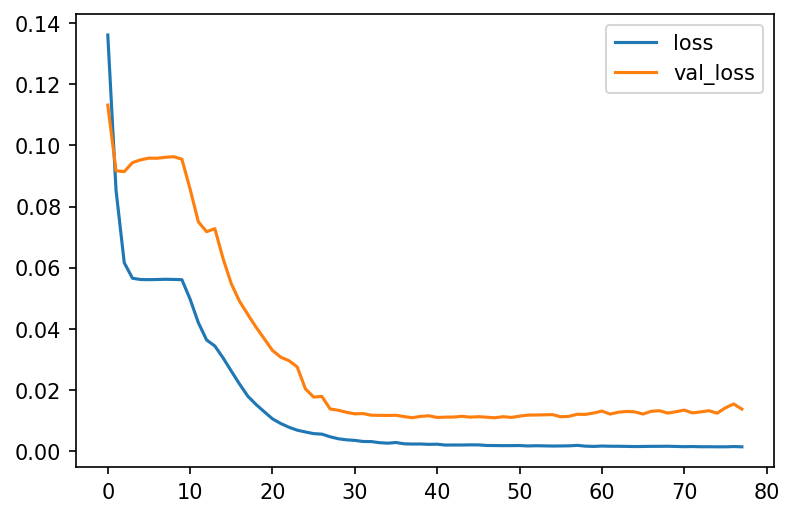

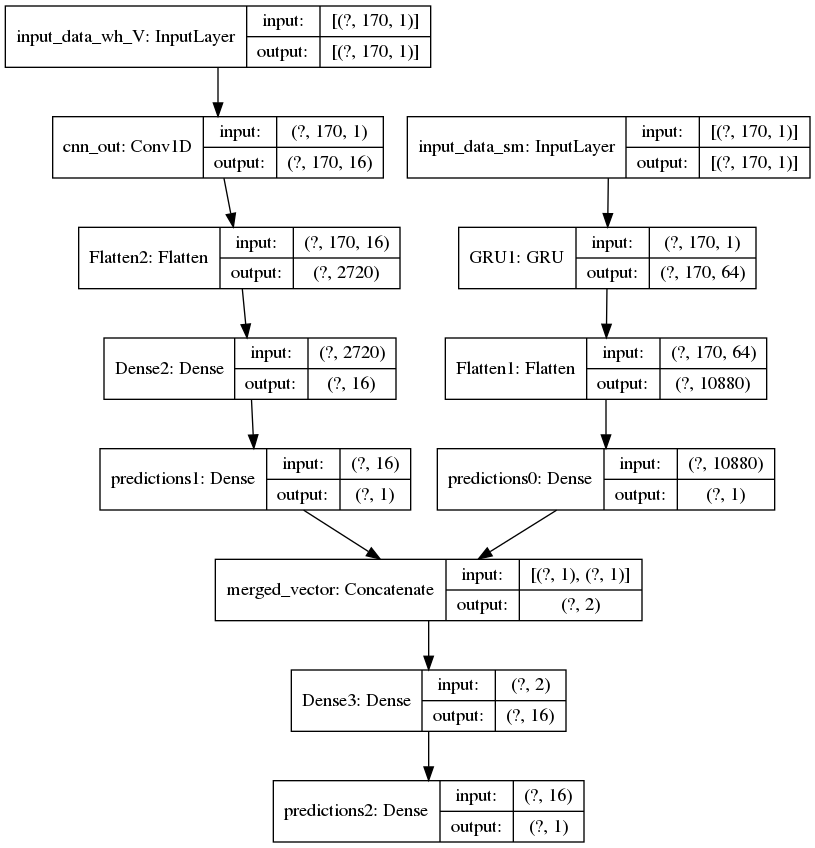

In [12]:
# keras-tf相关模块
import tensorflow as tf
from keras.models import load_model
from tensorflow.python.keras import backend as K  
from tensorflow.keras.models import * # Sequential, Model
from tensorflow.keras.layers import * # Dense, Dropout, BatchNormalization, LSTM, Conv1D, Flatten, GRU, Input
from tensorflow.keras import optimizers, regularizers
# from keras.layers import *
# 导入ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint,TensorBoard,Callback,ReduceLROnPlateau,EarlyStopping
# keras查看GPU模块
from keras.utils import *  # multi_gpu_model, plot_model
import time




# 单特征训练
def tain(lr=0.001, feature_size=170, hidden_dim=128, num_layers=2, 
         weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0, list_nums=4):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】
    score_list, result_list = [], []
    # 训练数据准备
#     train_x1, train_y1, test_x1, test_y1 = get_train_test(capacity, window_size=feature_size)
    train_x1, train_y1, test_x1, test_y1 = get_train_test_2(discharge, Battery_list0, 
                                                            feature_name='Voltage_measured', 
                                                            label_name='Capacity', 
                                                            window_size=feature_size, test_rat=0.2)

    # 归一化
    train_x1_, s1 = Fit_transform(train_x1,0,1)  # s1: <class 'sklearn.preprocessing._data.MinMaxScaler'>
    train_y1_, s2 = Fit_transform(train_y1.reshape(-1,1),0,1)
    test_x1_,  s3 = Fit_transform(test_x1,0,1)
    test_y1_,  s4 = Fit_transform(test_y1.reshape(-1,1),0,1)
    Extremum_matrix = [s1,s2,s3,s4]
    # 添加维度，编程网络输入三维
    train_x2, test_x2 = train_x1_.reshape(train_x1_.shape[0],feature_size,1), test_x1_.reshape(test_x1_.shape[0],feature_size,1)
    # shuffle 测试数据（样本后部分）
    train_x, train_y,_ = shuffle_data(train_x2, train_y1_)
    test_x, test_y,_ = shuffle_data(test_x2, test_y1_)
    print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

    # 模型配置
    optimizer = 'adam'  # optimizers.Adam(lr=0.001,decay=0.004)
#     model,strr = build_model_LSTM(optimizer, (170,1)) 
#     model,strr = build_model_cnn1d(optimizer,(170,1))  
#     model,strr = build_model_GRU(optimizer, (170,1))   
#     model,strr = build_model_CNN_LR(optimizer) 
#     model,strr = build_model_CNN_CNN(optimizer)
#     model,strr = build_model_CNN_LSTM(optimizer)
    model,strr = build_model_CNN_GRU(optimizer, (170,1))
#     model,strr = build_model_CNN_LSTM2(optimizer)
#     model,strr = build_model_CNN_GRU2(optimizer)

    
    
    checkpoint_save_dir='./test1/'
    EarlyStop=EarlyStopping(monitor='val_loss'  #'val_acc',
                            ,patience=30,verbose=1, mode='auto')
    checkpoint = ModelCheckpoint(os.path.join(checkpoint_save_dir, "model_%s_170-1_2.hdf5"%strr),
                                 monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint, EarlyStop]

    start_sampling = time.time()
    # hist_sampling = model.fit(X_train,y_train,
    hist_sampling = model.fit([train_x,train_x],train_y,
    #                           validation_split = 0.2, 
                              validation_data=([test_x,test_x], test_y),
                              batch_size=8, epochs=600,
                              callbacks=callbacks_list,#,reduce_lr],
                              shuffle=True,
                              verbose=1)
    end_sampling = time.time()
    print('训练结束！！')
    print('训练时间（分钟）：',(end_sampling-start_sampling)/60)

    score_sampling = model.evaluate([test_x,test_x],
                                     test_y, batch_size=8)
    # score_sampling = model.evaluate(X_test,y_test, batch_size=128)
    print(score_sampling)
    plt.figure(dpi=150)
    plt.plot(hist_sampling.history['loss'], label='loss')
#     plt.plot(hist_sampling.history['acc'], label='acc')
#     plt.plot(hist_sampling.history['val_acc'], label='val_acc')
    plt.plot(hist_sampling.history['val_loss'], label='val_loss')
    plt.legend()
    plt.savefig('NASA-27-%s-losscurve-2'%strr)
    plt.show()
    return model, train_x, train_y, test_x, test_y, train_x1, train_y1, test_x1, test_y1, Extremum_matrix, strr

# 0.004 0.018
# tain()
model, train_x, train_y, test_x, test_y, train_x1, train_y1, test_x1, test_y1, Extremum_matrix, strr = tain()
tf.keras.utils.plot_model(model,to_file='%s_2.png'%strr, show_shapes=True,show_layer_names=True)   

#         setup_seed(seed)
#         model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
#         model = model.to(device)

<class 'numpy.ndarray'> CNN1D_GRU1 (127, 170)


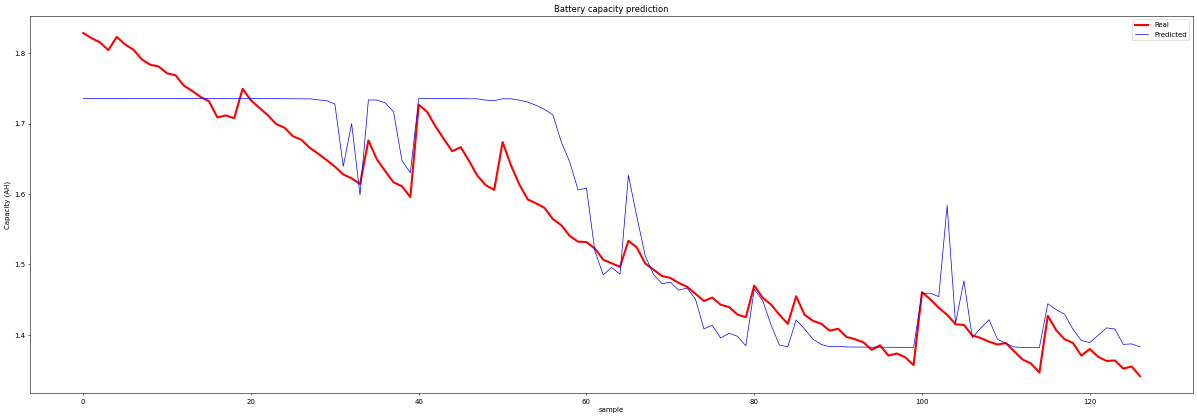

In [16]:
print(type(test_x1),strr,test_x1.shape)
# train_x1, train_y1, test_x1, test_y1
# xx = np.
test_x1_,  s5 = Fit_transform(test_x1,0,1)
test_y1_,  s6 = Fit_transform(test_y1.reshape(-1,1),0,1)

prediction=model.predict([test_x1_.reshape(test_x1.shape[0],170,1),test_x1_.reshape(test_x1.shape[0],170,1)])

prediction_ = Inverse_transform(prediction, s6)

# 12V-7AH/20HR各代号的含义：
# 1、12V：电池的额定电压。
# 2、7AH：电池的容量，表示该电瓶以7A放电可工作一小时,若以1A放电可工作7小时。
# 3、20HR：建议电池的放电速率为20小时，HR是Hour Rate即倍率的缩写。（20HR）20小时放电率，该电池适于0.35A放电20小时。也就是说不宜大电流放电。

# print(prediction_.shape,test_y1.shape)
# 绘图展示
plt.figure(figsize = (30,10),dpi=50)
plt.plot(test_y1.reshape(-1,1), color = 'red', label = 'Real',linewidth=3)
plt.plot(prediction_, color = 'b', label = 'Predicted',linewidth=1)
plt.title('Battery capacity prediction')
plt.xlabel('sample')
plt.ylabel('Capacity (AH)')
plt.legend()
plt.savefig('NASA-27-%s-testdata.png'%strr)
plt.show()


(509, 170) CNN1D_GRU1


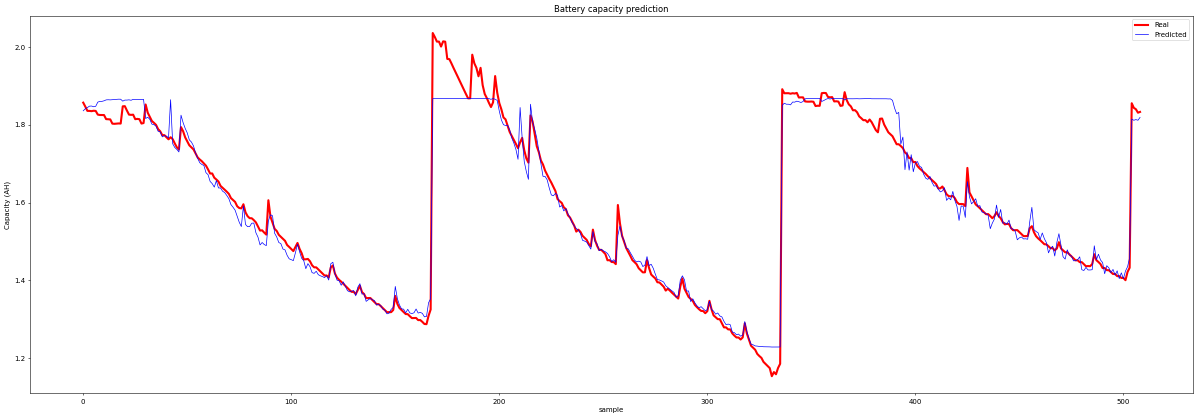

In [17]:
print(train_x1.shape,strr)
train_x1_,  s7 = Fit_transform(train_x1,0,1)
train_y1_,  s8 = Fit_transform(train_y1.reshape(-1,1),0,1)

# prediction2=model.predict(train_x1_.reshape(train_x1.shape[0],16,1))
prediction2=model.predict([train_x1_.reshape(train_x1.shape[0],170,1),train_x1_.reshape(train_x1.shape[0],170,1)])

prediction_2 = Inverse_transform(prediction2, s8)

# 12V-7AH/20HR各代号的含义：
# 1、12V：电池的额定电压。
# 2、7AH：电池的容量，表示该电瓶以7A放电可工作一小时,若以1A放电可工作7小时。
# 3、20HR：建议电池的放电速率为20小时，HR是Hour Rate即倍率的缩写。（20HR）20小时放电率，该电池适于0.35A放电20小时。也就是说不宜大电流放电。

# print(prediction_.shape,test_y1.shape)
# 绘图展示
plt.figure(figsize = (30,10),dpi=50)
plt.plot(train_y1.reshape(-1,1), color = 'red', label = 'Real',linewidth=3)
plt.plot(prediction_2, color = 'b', label = 'Predicted',linewidth=1)
plt.title('Battery capacity prediction')
plt.xlabel('sample')
plt.ylabel('Capacity (AH)')
plt.legend()
plt.savefig('NASA-27-%s-traindata.png'%strr)
plt.show()


In [18]:
# sklearn科学计算模块
# keras-sklearn计算相关模块
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor,KerasClassifier
# sklearn计算模块
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,classification_report,confusion_matrix
from sklearn.svm import SVC, SVR
# sklearn数据处理模块
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve, KFold, GridSearchCV
from sklearn.model_selection import ShuffleSplit,train_test_split,learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def eva_ind(data_gt,data_pre):
    
    gt = data_gt
    pre = data_pre
    pre_mean = np.mean(gt)

    # 获取绝对值误差
    Abs = []
    Abs_error = []
    for i in range(0,len(gt)):
    #     print(i)
        Abs.append(abs(pre[i]-gt[i])) # 绝对误差
        Abs_error.append(abs(gt[i]-pre_mean)) # 标签-预测平均值

    mse = mean_squared_error(pre, gt) # 均方误差
    rmse = np.sqrt(mean_squared_error(pre, gt)) # 根均方误差
    r2_s = r2_score(gt, pre) # 决定系数，反映因变量的全部变异能通过回归关系被自变量解释的比例

    # 平均偏差
    pre_mean_error = np.mean(Abs_error)
    # print(pre_mean_error)
    # 平均误差除以预测集平均值
    relative_error =  pre_mean_error/ pre_mean   

    # 平均绝对值误差（mean_absolute_error）
    mae =  mean_absolute_error(gt,pre)
        # 真实值与
    print(f"测试集均方误差(MSE)：{mse}")
    print(f"测试集根均方误差(RMSE)：{rmse}")
    print(f"测试集平均绝对误差：{mae}")
    print(f"测试集R^2：{r2_s}")
    print(f"测试集相对平均误差：{relative_error*100}%")
print(strr)
print('--- test prediction')
eva_ind(test_y1,prediction_)
print('--- train prediction_')
eva_ind(train_y1,prediction_2)


# CNN1D
# --- test prediction
# 测试集均方误差(MSE)：0.02639219715009841
# 测试集根均方误差(RMSE)：0.1624567547075172
# 测试集平均绝对误差：0.13086830369124186
# 测试集R^2：-0.22895137439334046
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：9.797500193796826e-05
# 测试集根均方误差(RMSE)：0.009898232263286625
# 测试集平均绝对误差：0.007040211515937331
# 测试集R^2：0.9977500485911877
# 测试集相对平均误差：11.378318908349675%

# LSTM2
# --- test prediction
# 测试集均方误差(MSE)：0.007885471285159576
# 测试集根均方误差(RMSE)：0.08880017615500307
# 测试集平均绝对误差：0.07263285643814571
# 测试集R^2：0.6328134138085602
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.0015524487791713482
# 测试集根均方误差(RMSE)：0.039401126623122694
# 测试集平均绝对误差：0.029833511887819835
# 测试集R^2：0.9643487190741045
# 测试集相对平均误差：11.378318908349675%


# GRU3
# --- test prediction
# 测试集均方误差(MSE)：0.006538325427870127
# 测试集根均方误差(RMSE)：0.0808599123662036
# 测试集平均绝对误差：0.06368652294427773
# 测试集R^2：0.6955431950165636
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.0020327400112272074
# 测试集根均方误差(RMSE)：0.04508591810340794
# 测试集平均绝对误差：0.03398627277085501
# 测试集R^2：0.9533190491294331
# 测试集相对平均误差：11.378318908349675%



# CNN1D_LR
# --- test prediction
# 测试集均方误差(MSE)：0.006662174569848377
# 测试集根均方误差(RMSE)：0.08162214509462722
# 测试集平均绝对误差：0.06544558091429582
# 测试集R^2：0.6897761657546198
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.0010044258015330027
# 测试集根均方误差(RMSE)：0.03169267741187233
# 测试集平均绝对误差：0.021628105900658265
# 测试集R^2：0.9769338177850965
# 测试集相对平均误差：11.378318908349675%

# CNN1D_GRU1
# --- test prediction
# 测试集均方误差(MSE)：0.004236662852792879
# 测试集根均方误差(RMSE)：0.06508965242488916
# 测试集平均绝对误差：0.053121232456408235
# 测试集R^2：0.8027200006816558
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.0007186960934813258
# 测试集根均方误差(RMSE)：0.0268085078563005
# 测试集平均绝对误差：0.019061697481570924
# 测试集R^2：0.9834954707216023
# 测试集相对平均误差：11.378318908349675%

# CNN1D_GRU1---300epoch
# --- test prediction
# 测试集均方误差(MSE)：0.0019618167127009836
# 测试集根均方误差(RMSE)：0.044292400168663065
# 测试集平均绝对误差：0.034112308154005226
# 测试集R^2：0.9086481003582262
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.0008750162915798439
# 测试集根均方误差(RMSE)：0.029580674292176708
# 测试集平均绝对误差：0.021497038871788658
# 测试集R^2：0.9799056483895723
# 测试集相对平均误差：11.378318908349675%



# CNN1D_GRU2
# --- test prediction
# 测试集均方误差(MSE)：0.016519295901460385
# 测试集根均方误差(RMSE)：0.1285274130349646
# 测试集平均绝对误差：0.08907448481136272
# 测试集R^2：0.2307797912143772
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.001773620128699526
# 测试集根均方误差(RMSE)：0.04211436962248783
# 测试集平均绝对误差：0.03215486991877206
# 测试集R^2：0.9592696195118006
# 测试集相对平均误差：11.378318908349675%

# CNN1D_GRU2---130epoch
# --- test prediction
# 测试集均方误差(MSE)：0.006240816174562992
# 测试集根均方误差(RMSE)：0.07899883653929969
# 测试集平均绝对误差：0.05203144748631923
# 测试集R^2：0.7093966989013349
# 测试集相对平均误差：8.51458683366669%
# --- train prediction_
# 测试集均方误差(MSE)：0.0010613235390733423
# 测试集根均方误差(RMSE)：0.032577960941000315
# 测试集平均绝对误差：0.021501428473086354
# 测试集R^2：0.975627187091502
# 测试集相对平均误差：11.378318908349675%

CNN1D_GRU1
--- test prediction
测试集均方误差(MSE)：0.0032781680792714086
测试集根均方误差(RMSE)：0.0572552886576551
测试集平均绝对误差：0.043137084358800745
测试集R^2：0.8473522631101612
测试集相对平均误差：8.51458683366669%
--- train prediction_
测试集均方误差(MSE)：0.0010868409896406005
测试集根均方误差(RMSE)：0.032967271492202695
测试集平均绝对误差：0.020809398326407748
测试集R^2：0.9750411904319719
测试集相对平均误差：11.378318908349675%


In [13]:
"""
27个样本
CNN1D
--- test prediction
测试集均方误差(MSE)：0.040366890131129415
测试集根均方误差(RMSE)：0.20091513166292232
测试集平均绝对误差：0.12540696893287445
测试集R^2：0.6693668123235581
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.01582276947351823
测试集根均方误差(RMSE)：0.12578859039482965
测试集平均绝对误差：0.0451067472812176
测试集R^2：0.9411456364596407
测试集相对平均误差：27.014767290616376%

LSTM2
--- test prediction
测试集均方误差(MSE)：0.04323706049687612
测试集根均方误差(RMSE)：0.2079352314949925
测试集平均绝对误差：0.11062430123312263
测试集R^2：0.6458581007503204
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.01734343657450634
测试集根均方误差(RMSE)：0.1316944819440296
测试集平均绝对误差：0.04663090267870282
测试集R^2：0.9354893640520064
测试集相对平均误差：27.014767290616376%



CNN1D_LR
--- test prediction
测试集均方误差(MSE)：0.050989488885775015
测试集根均方误差(RMSE)：0.22580852261545625
测试集平均绝对误差：0.14153322689833436
测试集R^2：0.5823602662099694
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.016839169785641303
测试集根均方误差(RMSE)：0.1297658267250716
测试集平均绝对误差：0.03485823287644699
测试集R^2：0.9373650344877581
测试集相对平均误差：27.014767290616376%


CNN1D_CNN1D
--- test prediction
测试集均方误差(MSE)：0.06485758870551062
测试集根均方误差(RMSE)：0.25467153100712026
测试集平均绝对误差：0.16838244528969018
测试集R^2：0.4687707864279166
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.01753803091127434
测试集根均方误差(RMSE)：0.13243123087578074
测试集平均绝对误差：0.045693401432716274
测试集R^2：0.9347655510774063
测试集相对平均误差：27.014767290616376%

CNN1D_LSTM1
--- test prediction
测试集均方误差(MSE)：0.07073097548505354
测试集根均方误差(RMSE)：0.2659529572782629
测试集平均绝对误差：0.18002786663901454
测试集R^2：0.42066362268385094
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.017937397007850107
测试集根均方误差(RMSE)：0.133930567862046
测试集平均绝对误差：0.055995232279362143
测试集R^2：0.9332800691917666
测试集相对平均误差：27.014767290616376%

CNN1D_GRU1
--- test prediction
测试集均方误差(MSE)：0.07507156320618813
测试集根均方误差(RMSE)：0.27399190354130565
测试集平均绝对误差：0.18629133012897728
测试集R^2：0.38511116001045753
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.017345250650387348
测试集根均方误差(RMSE)：0.13170136920467967
测试集平均绝对误差：0.040759963388814054
测试集R^2：0.9354826164164822
测试集相对平均误差：27.014767290616376%


CNN1D_LSTM2
--- test prediction
测试集均方误差(MSE)：0.07623181228499039
测试集根均方误差(RMSE)：0.2761010906986613
测试集平均绝对误差：0.18860785050729575
测试集R^2：0.37560790498692487
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.01393013460766462
测试集根均方误差(RMSE)：0.11802599123779736
测试集平均绝对误差：0.034019644697834056
测试集R^2：0.948185479935243
测试集相对平均误差：27.014767290616376%


CNN1D_GRU2
--- test prediction
测试集均方误差(MSE)：0.06885049342753088
测试集根均方误差(RMSE)：0.26239377551216964
测试集平均绝对误差：0.17582147749486018
测试集R^2：0.436066091762528
测试集相对平均误差：18.676354072287698%
--- train prediction_
测试集均方误差(MSE)：0.01573655187868798
测试集根均方误差(RMSE)：0.12544541394043857
测试集平均绝对误差：0.0486259733606156
测试集R^2：0.9414663313720077
测试集相对平均误差：27.014767290616376%


"""




"""
LSTM2-(05-018)-容量
--- test prediction
测试集均方误差(MSE)：0.00023966289652662987
测试集根均方误差(RMSE)：0.01548104959383019
测试集平均绝对误差：0.010501952931301914
测试集R^2：0.9669668009565185
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.0003288080711828095
测试集根均方误差(RMSE)：0.01813306568627626
测试集平均绝对误差：0.010693315171653265
测试集R^2：0.9883091397802551
测试集相对平均误差：9.055994015555727%

CNN1D-(05-018)-容量
--- test prediction
测试集均方误差(MSE)：0.0002323281231515903
测试集根均方误差(RMSE)：0.015242313576081233
测试集平均绝对误差：0.010110452687513542
测试集R^2：0.9679777669105647
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.00033319614608990847
测试集根均方误差(RMSE)：0.01825366116947251
测试集平均绝对误差：0.012247011950276181
测试集R^2：0.9881531205858719
测试集相对平均误差：9.055994015555727%

GRU3-(05-015)-容量
--- test prediction
测试集均方误差(MSE)：0.0002287943351844333
测试集根均方误差(RMSE)：0.015125949067229907
测试集平均绝对误差：0.009713810179947689
测试集R^2：0.9684648357184125
测试集相对平均误差：5.360328947805525%
--- train prediction_
测试集均方误差(MSE)：0.0004069002326348896
测试集根均方误差(RMSE)：0.02017176820794076
测试集平均绝对误差：0.01056620091093283
测试集R^2：0.9855325517831606
测试集相对平均误差：9.055994015555727%


CNN1D+CNN1D-
--- test prediction
测试集均方误差(MSE)：0.00024393199378423903
测试集根均方误差(RMSE)：0.015618322374193683
测试集平均绝对误差：0.009766953932471182
测试集R^2：0.9663783830516598
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.0003575179766585768
测试集根均方误差(RMSE)：0.01890814577526249
测试集平均绝对误差：0.009694251588587357
测试集R^2：0.987288351298294
测试集相对平均误差：9.055994015555727%

CNN1D+LR-
--- test prediction
测试集均方误差(MSE)：0.00026620054576812494
测试集根均方误差(RMSE)：0.01631565339691074
测试集平均绝对误差：0.011260282532168767
测试集R^2：0.9633090656030489
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.0004270440649665279
测试集根均方误差(RMSE)：0.020665044518861503
测试集平均绝对误差：0.012640350206947244
测试集R^2：0.9848163323569402
测试集相对平均误差：9.055994015555727%

CNN1D+LSTM1-
--- test prediction
测试集均方误差(MSE)：0.0002805039129130459
测试集根均方误差(RMSE)：0.016748251040423472
测试集平均绝对误差：0.010363606223771624
测试集R^2：0.961337604935846
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.0003431047203075095
测试集根均方误差(RMSE)：0.018523086144255484
测试集平均绝对误差：0.009653881126639093
测试集R^2：0.9878008185400667
测试集相对平均误差：9.055994015555727%

CNN1D+GRU1-
--- test prediction
测试集均方误差(MSE)：0.0002606825293596219
测试集根均方误差(RMSE)：0.01614566596209713
测试集平均绝对误差：0.009745423539555657
测试集R^2：0.9640696244421056
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.00040735209855444253
测试集根均方误差(RMSE)：0.020182965554012187
测试集平均绝对误差：0.011189999739052868
测试集R^2：0.9855164855677403
测试集相对平均误差：9.055994015555727%

CNN1D+LSTM2-
--- test prediction
测试集均方误差(MSE)：0.00024193514835970138
测试集根均方误差(RMSE)：0.015554264635774376
测试集平均绝对误差：0.01070765969308011
测试集R^2：0.9666536121059848
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.0003675522936159113
测试集根均方误差(RMSE)：0.019171653387642686
测试集平均绝对误差：0.011846027286123674
测试集R^2：0.9869315784352471
测试集相对平均误差：9.055994015555727%


CNN1D+GRU2-
--- test prediction
测试集均方误差(MSE)：0.00029627795194351263
测试集根均方误差(RMSE)：0.017212726452933383
测试集平均绝对误差：0.010893999484499798
测试集R^2：0.9591634387275395
测试集相对平均误差：5.360328947805525%
--- train prediction
测试集均方误差(MSE)：0.00025712257065268015
测试集根均方误差(RMSE)：0.016035041959804163
测试集平均绝对误差：0.00959326131614557
测试集R^2：0.9908579372093007
测试集相对平均误差：9.055994015555727%


"""

'\nLSTM2-(05-018)-容量\n--- test prediction\n测试集均方误差(MSE)：0.00023966289652662987\n测试集根均方误差(RMSE)：0.01548104959383019\n测试集平均绝对误差：0.010501952931301914\n测试集R^2：0.9669668009565185\n测试集相对平均误差：5.360328947805525%\n--- train prediction\n测试集均方误差(MSE)：0.0003288080711828095\n测试集根均方误差(RMSE)：0.01813306568627626\n测试集平均绝对误差：0.010693315171653265\n测试集R^2：0.9883091397802551\n测试集相对平均误差：9.055994015555727%\n\nCNN1D-(05-018)-容量\n--- test prediction\n测试集均方误差(MSE)：0.0002678508003343722\n测试集根均方误差(RMSE)：0.016366147999281083\n测试集平均绝对误差：0.011092402991777925\n测试集R^2：0.96308160783487\n测试集相对平均误差：5.360328947805525%\n--- train prediction\n测试集均方误差(MSE)：0.00043120200364261816\n测试集根均方误差(RMSE)：0.020765404008653867\n测试集平均绝对误差：0.011082255870632522\n测试集R^2：0.9846684957187166\n测试集相对平均误差：9.055994015555727%\n\nGRU3-(05-015)-容量\n--- test prediction\n测试集均方误差(MSE)：0.00025840616280380985\n测试集根均方误差(RMSE)：0.016075016727948057\n测试集平均绝对误差：0.01078761913100423\n测试集R^2：0.964383380432807\n测试集相对平均误差：5.360328947805525%\n--- train prediction\n测

In [95]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):  # 【window_size:-1】
        sequence = text[i:i+window_size]      # 特征
        target = text[i+1:i+1+window_size]    # 标签,延后的序列。。。？？？

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8):
    
    # 该部分是选取一个step_time序列为测试集
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]  # 且分出训练数据和测试数据
#     print(len(data_dict),len(data_sequence),len(train_data),len(test_data))
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)   # 制作数据集特征和标签
#     print(len(train_x[0]),len(train_y[0]))
    
    # 余下数据生成训练集
    for k, v in data_dict.items():  # 返回可遍历的(键, 值) 元组数组，然后便利
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
                            # np.r_：是按列连接两个矩阵，就是把两矩阵上下相加，要求列数相等，类似于pandas中的concat()。
                            # np.c_：是按行连接两个矩阵，就是把两矩阵左右相加，要求行数相等，类似于pandas中的merge()。
    return train_x, train_y, list(train_data), list(test_data)

# 相对误差
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    
    
def setup_seed(seed):
    # 设置随机数种子，为所有的模式提供固定随机情况，使得实验课复现
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [62]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, n_class=1, mode='LSTM'):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.cell = nn.LSTM(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        if mode == 'GRU':
            self.cell = nn.GRU(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        elif mode == 'RNN':
            self.cell = nn.RNN(input_size=input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, n_class)
 
    def forward(self, x):           # x shape: (batch_size, seq_len, input_size)
        out, _ = self.cell(x) 
        out = out.reshape(-1, self.hidden_dim)
        out = self.linear(out)      # out shape: (batch_size, n_class=1)
        return out

In [194]:
from torchsummary import summary

def tain(lr=0.001, feature_size=16, hidden_dim=128, num_layers=2, 
         weight_decay=0.0, mode = 'LSTM', EPOCH=1000, seed=0):
    # Battery_list ： 样本列表
    # Battery      ：【序号，电池容量】

    
    score_list, result_list = [], []
    for i in range(4):
        name = Battery_list[i]  # 样本列表
        # 划分数据集
        train_x, train_y, train_data, test_data = get_train_test(capacity, name, window_size=feature_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(input_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers, mode=mode)
        model = model.to(device)
#         net11 = model
#         summary(net11)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()  # 生成的测试集
        loss_list, y_ = [0], []     # 声明loss和pre容器
        mae, rmse, re = 1, 1, 1     # 初始化评价指标
        score_, score = 1,1         # 初始化评价列表
        
        for epoch in range(EPOCH):
            # 数据处理
            X = np.reshape(train_x/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)#(batch_size, seq_len, input_size)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)# shape 为 (batch_size, 1)
            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            
            output= model(X)                   # 预测结果
            output = output.reshape(-1, 1)
            loss = criterion(output, y)        # 计算loss
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy()    #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)                 # shape: (batch_size, 1, input_size)
                    
                    pred = model(x)
#                     print('???????????????????????/',pred.shape)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)                          #测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)                     #保存输出序列最后一个点的预测值
                y_.append(point_list)                                 #保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            score = [re, mae, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()
            
        score_list.append(score_)
        result_list.append(y_[-1])
    return score_list, result_list,loss_list,model

In [195]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [196]:
window_size = 16     # step_time
EPOCH = 1000         
lr = 0.001           # learning rate
hidden_dim = 256     # 隐层维度，神经元个数
num_layers = 2       # 隐层层数
weight_decay = 0.0   # 学习率衰减
mode = 'LSTM'        # RNN, LSTM, GRU
Rated_Capacity = 2.0 # 额定容量
 
# 进行十次随机数固定实验，并输出loss\MAE\RMSE\RE
SCORE = []
RES = []
LOSS = []
seed = 0
# for seed in range(2):
#     print('seed: ', seed)
#     score_list, res, loss_list = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
#                          weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
#     print('------------------------------------------------------------------')
#     for s in score_list:  
#         SCORE.append(s)
# #     if seed == 2: LOSS.append(loss_list)
# # plt.plot(res, 'b', label='loss')


score_list, res, loss_list, model = tain(lr=lr, feature_size=window_size, hidden_dim=hidden_dim, num_layers=num_layers, 
                         weight_decay=weight_decay, mode=mode, EPOCH=EPOCH, seed=seed)
print('------------------------------------------------------------------')
for s in score_list:  
    SCORE.append(s)

mlist = ['re', 'mae', 'rmse']
for i in range(3):
    s = [line[i] for line in SCORE] 
    print(mlist[i] + ' mean: {:<6.4f}'.format(np.mean(np.array(s)))) # 输出均值
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1099 | RMSE:0.1247 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.0914 | RMSE:0.1031 | RE:1.0000
epoch:299 | loss:0.0003 | MAE:0.0705 | RMSE:0.0830 | RE:0.0566
epoch:399 | loss:0.0002 | MAE:0.0563 | RMSE:0.0702 | RE:0.0755
4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0005 | MAE:0.1216 | RMSE:0.1448 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1183 | RMSE:0.1418 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1050 | RMSE:0.1253 | RE:1.0000
epoch:399 | loss:0.0002 | MAE:0.1055 | RMSE:0.1217 | RE:1.0000
epoch:499 | loss:0.0001 | MAE:0.1188 | RMSE:0.1325 | RE:0.5889
epoch:599 | loss:0.0001 | MAE:0.1353 | RMSE:0.1486 | RE:0.6000
4 168 17 151
16 16
sample size: 421
epoch:99 | loss:0.0007 | MAE:0.1338 | RMSE:0.1542 | RE:1.0000
epoch:199 | loss:0.0004 | MAE:0.1168 | RMSE:0.1289 | RE:0.1258
epoch:299 | loss:0.0003 | MAE:0.1216 | RMSE:0.1247 | RE:0.3444
4 132 17 115
16 16
sample size: 457
epoch:99 | loss:0.0007 | MAE:0.0566 | RM